In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal 
import scipy.io
from scipy.io import wavfile
from IPython.display import display, Audio, HTML
from sklearn.mixture import GaussianMixture

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")


# Load a remote WAVE file given its URL, and return the sample rate and waveform
def wavreadurl( url):
    import urllib.request, io, scipy.io.wavfile
    f = urllib.request.urlopen( urllib.request.Request( url))
    sr,s = scipy.io.wavfile.read( io.BytesIO( f.read()))
    return sr, s.astype( 'float32')/32768

def sound( x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    display( HTML( 
    '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label + 
    '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
    ))
    
def make_sine( frequency=440, duration=1, sample_rate=8000):
    # YOUR CODE HERE
    x = [np.sin(2 * np.pi * i * frequency / sample_rate) for i in range(0, duration * sample_rate)]
    return x
    

In [ ]:
def stft(input_sound, dft_size=256, hop_size=64, zero_pad=0, window=np.hanning(256)):
    # YOUR CODE HERE
    # 1. create windowed sound matrix
    num_hop = (len(input_sound)-dft_size)//hop_size+1
    sound_segments = np.zeros(((dft_size+zero_pad)//2+1, num_hop), dtype = 'complex_')
    i = 0
    col_idx = 0
    while(col_idx <= len(input_sound)-dft_size):
        windowed_segment = input_sound[col_idx:col_idx+dft_size]* window
        sound_segments[:,i] = np.fft.rfft(windowed_segment, n = dft_size+zero_pad)
        i += 1
        col_idx += hop_size
       
    # Return a complex-valued spectrogram (frequencies x time)
    return sound_segments

def istft( stft_output, dft_size=256, hop_size=64, zero_pad=0, window=np.hanning(256)):
    # YOUR CODE HERE
    num_hop = len(stft_output[0])
    sound_length = (num_hop - 1) * hop_size + dft_size+zero_pad
    reconstruct_sound = np.zeros(sound_length)
    time_stamp = 0
    for col in range(0, len(stft_output[0])):
        ifft_slice = np.fft.irfft(stft_output[:,col],n=dft_size+zero_pad)
        reconstruct_sound[time_stamp:time_stamp+dft_size] += window*ifft_slice[0:dft_size]
        time_stamp += hop_size
   
    return reconstruct_sound

def plot_spectrum_f(stft, title):
    plt.figure(figsize=(15, 3))
    plt.pcolormesh(1000 * np.abs(stft) ** 0.5)
    plt.title(title)
    plt.show()

In [ ]:
def lowpass_firwin(ntaps, fc, fs, window='hamming'):
    nyq = 0.5 * fs
    lpf_firwin = signal.firwin(ntaps, fc, nyq=nyq, pass_zero="lowpass", window=window)
    return lpf_firwin

# FUCK THE SHIT ABOVE, LET'S START OVER

## OLA without adaptive

In [ ]:
def fill_matrix(audio_buffer_total, len_fir):
    num_row = len(audio_buffer_total)-len_fir+1
    m = np.zeros((num_row, len_fir))
    for i in range(num_row):
        m[i,:] = audio_buffer_total[i:i+len_fir]
    return m
    

def neo_ola_calc(audio_buffer, prev_audio_buffer, fir):
    len_buffer_in = len(audio_buffer)
    len_fir = len(fir)
        
    audio_buffer_total = np.concatenate((prev_audio_buffer, audio_buffer))
    audio_matrix = fill_matrix(audio_buffer_total, len_fir)
    print(audio_matrix)
    
    filter_result = audio_matrix @ fir
    
    return filter_result
    
def neo_ola_stream(audio, fir, buffer_size):
    num_buffer = int(len(audio) // buffer_size)
    result = np.zeros(num_buffer * buffer_size)
    for i in range(num_buffer):
        if i == 0:
            prev_audio_buffer = np.zeros(buffer_size-len(fir))
        else:
            prev_audio_buffer = audio[buffer_size*i-(buffer_size-len(fir)): buffer_size*i]
        
        curr_audio_buffer = audio[buffer_size*i: buffer_size*(i+1)]
        ola_calc_result = neo_ola_calc(curr_audio_buffer, prev_audio_buffer, fir)
        
        result[buffer_size*i:buffer_size*(i+1)] = ola_calc_result
    
    return result

## OLA with adaptive

In [ ]:
# CGD(audio_matrix, fir, reference_buffer)
def CGD(A, x, b, num_iter=10, lr=0.001):
    r = b - A @ x
    p = r
#     print('p shsape:' ,p.shape)
#     print('A shape: ', A.shape)
#     k = 0
    for i in range(num_iter):
        a_num = r.T @ r
        a_den = p.T @ A @ p + 0.00000001
        a = a_num / a_den
        
        x_next = x + a * p
        r_next = r - a * A @ p
        
        beta_num = r_next.T @ r_next
        beta_den = r.T @ r + 0.00000001
        beta = beta_num/beta_den
        
        p_next = r_next + beta * p
        
        # update
        p = p_next
        r = r_next
        x = x_next
        
#         print(a, beta)
        
    return x

def LMS(A, x, b, lr=0.001):
    pred = A @ x
    error = b - pred
    
    step_vector = A @ error
    
    w_next = x + lr * step_vector
    
            
    return w_next

In [ ]:
def fill_matrix(audio_buffer_total, len_fir):
    num_row = len(audio_buffer_total)-len_fir+1
    m = np.zeros((num_row, len_fir))
    for i in range(num_row):
        m[i,:] = audio_buffer_total[i:i+len_fir]
    return m

def neo_ola_calc_cgd(audio_buffer, prev_audio_buffer, reference_buffer, fir):
    # Coeff_size
    len_fir = len(fir)
        
    audio_buffer_total = np.concatenate((prev_audio_buffer, audio_buffer))
    audio_matrix = fill_matrix(audio_buffer_total, len_fir)
    
    
    filter_result = audio_matrix @ fir
        
    new_fir = CGD(audio_matrix, fir, reference_buffer)
    
    return filter_result, new_fir

def neo_ola_stream_cgd(audio, reference, fir, prev_audio_buffer_in):
    loss_lst = []
    buffer_size = len(fir)
    num_buffer = int(len(audio) // buffer_size)
    result = np.zeros(num_buffer * buffer_size)
#     print("result length: ", len(result))
#     print(len(audio), len(reference))
    
    for i in range(num_buffer):
        if i == 0:
            prev_audio_buffer = prev_audio_buffer_in
        else:
            prev_audio_buffer = audio[buffer_size*i-(len(fir)-1): buffer_size*i]
        
        if i == num_buffer-1:
            prev_audio_buffer_out = audio[-(len(fir)-1):]
        
        curr_audio_buffer = audio[buffer_size*i: buffer_size*(i+1)]
        curr_reference_buffer = reference[buffer_size*i: buffer_size*(i+1)]
        ola_calc_result, update_fir = neo_ola_calc_cgd(curr_audio_buffer, prev_audio_buffer, curr_reference_buffer,fir)
        
        result[buffer_size*i:buffer_size*(i+1)] = ola_calc_result
        # fir = update_fir
        
        # loss_val = np.sum((ola_calc_result-curr_reference_buffer)**2)
        # loss_lst.append(loss_val)
        
#         print(result.shape)
    
    return result, fir, loss_lst, prev_audio_buffer_out

def outer_stream_loop(audio, reference, fir):
    num_block = int(len(audio)//480)
    outer_result = np.zeros(num_block * 480)
    outer_loss_lst = []
    
    # start streaming
    prev_audio_buffer = np.zeros(len(fir)-1)
    for i in range(num_block):
        # obtain current reference and input block (size 480)
        curr_audio_buffer_480 = audio[480*i: 480*(i+1)]
        curr_reference_buffer_480 = reference[480*i: 480*(i+1)]
        
        result_480, fir, loss_lst_480, prev_audio_buffer = neo_ola_stream_cgd(curr_audio_buffer_480, 
                                                                                  curr_reference_buffer_480, 
                                                                                  fir, prev_audio_buffer)
        # record sub results and loss
        outer_loss_lst += loss_lst_480
        outer_result[480*i: 480*(i+1)] = result_480
        
    return outer_result, fir, outer_loss_lst
            
            
        
    
    
    
    

In [42]:
# sine_440 = np.array(make_sine(frequency=440, duration=1, sample_rate=8000))
# sine_880 = np.array(make_sine(frequency=880, duration=1, sample_rate=8000))

# sine_440_880 = np.add(sine_440,sine_880)
# stft_440880 = stft(sine_440_880)
# plot_spectrum_f(stft_440880, '440+880')

In [43]:
reference = sine_440
audio = sine_440_880
result, fir, loss_lst = outer_stream_loop(audio, reference, np.zeros(16))

<Figure size 640x480 with 0 Axes>

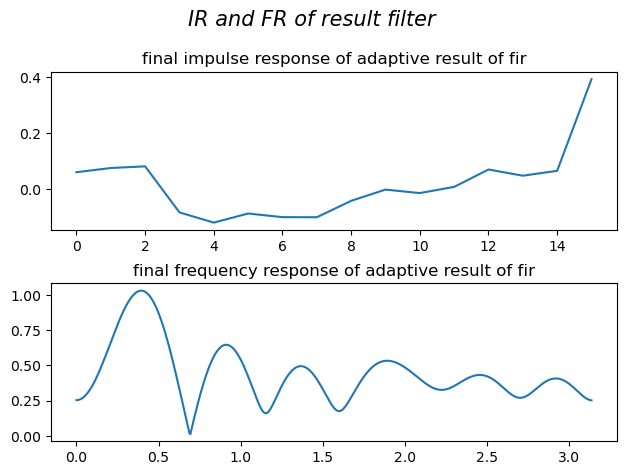

In [44]:
w, freq_resp = signal.freqz(fir, 1)

plt.figure()
plt.subplots(2, 1)
plt.subplot(2, 1, 1)
plt.title('final impulse response of adaptive result of fir')
plt.plot(fir)
plt.subplot(2, 1, 2)
plt.title('final frequency response of adaptive result of fir')
plt.plot(w, abs(freq_resp))
plt.tight_layout()
plt.suptitle('IR and FR of result filter', style='italic', fontsize=15)
plt.subplots_adjust(top=0.85)
plt.show()

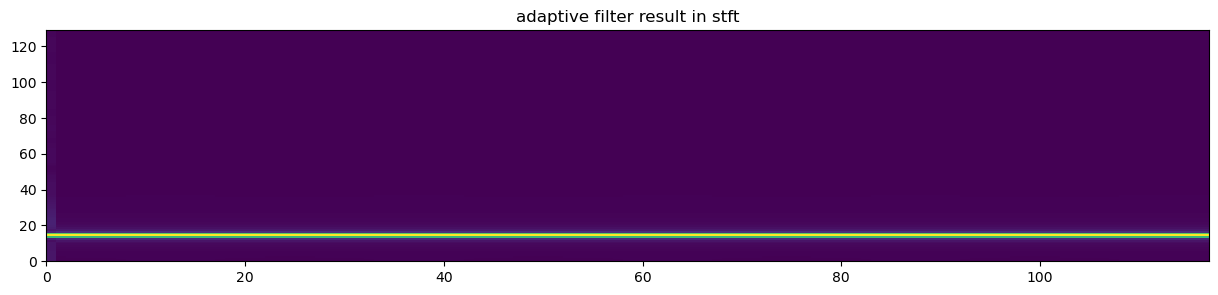

In [45]:
stft_result = stft(result)
plot_spectrum_f(stft_result, 'adaptive filter result in stft')

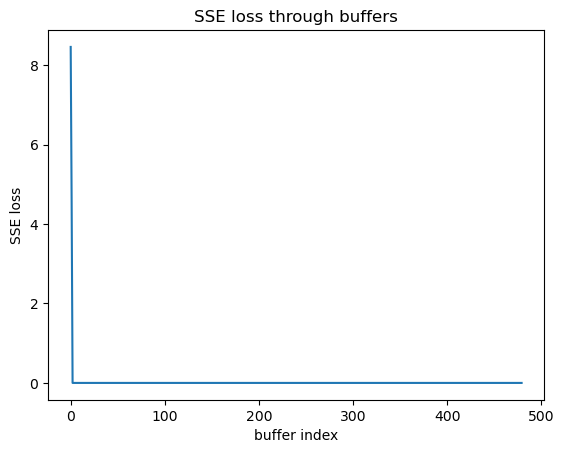

In [46]:
plt.figure()
plt.plot(loss_lst)
plt.title('SSE loss through buffers')
plt.xlabel('buffer index')
plt.ylabel('SSE loss')
plt.show()
# print(loss_lst)

# next step

1. auto-regressive moving average model (test robustness)